In [3]:
import unittest
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from random import randint
from tqdm import tqdm
from scipy.stats import entropy
import math
from collections import Counter
import pandas as pd
import hashlib
import libnum
import array, random
from classgroup import *
from classgroup_helper import *
import math
import random
import sympy
import time
import json
from scipy.stats import chisquare
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression

In [4]:
## this code is taken from here: https://github.com/coinstudent2048/bquadform

# Miscellaneous utilities for bquadform.py
#
# Use this code only for prototyping

# integer square root (floor)
# reference: Algorithm 1.7.1 (p.38) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def isqrt(n):
    if not isinstance(n, int):
        raise TypeError("input is not integer")
    if n < 0:
        raise ValueError("input is negative")
    if n == 0:
        return 0
    # [Initialize]
    x = 1 << (n.bit_length() + 2 >> 1)
    while True:
        # [Newtonian step]
        y = (x + n // x) >> 1
        # [Finished?]
        if y >= x:
            return x
        x = y

# # integer square root (ceiling)
# def isqrt_ceil(n):
#     if n == 0:
#         return 0
#     else:
#         return 1 + isqrt(n - 1)

# Euclidean division: always ensures that
# 0 <= r < |b| regardless of sign of divisor
def divmod_euclid(a, b):
    q, r = divmod(a, b)   # divmod uses floor division
    if r < 0:
        q += 1
        r -= b
    return (q, r)

# extended Euclidean algorithm (assumes a >= 0 & b >= 0)
# reference: Algorithm 1.3.6 (p.16) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def ext_euclid(a, b, u=1, v1=0):
    # [Initialize]
    d = a
    # v to be computed in ext_euclid_front()
    if b == 0:
        return (u, d)
    v3 = b
    # [Finished?]
    while v3 != 0:
        # [Euclidean step]
        q, t3 = divmod(d, v3)
        t1 = u - q * v1
        u = v1
        d = v3
        v1 = t1
        v3 = t3
    # [Finished?] cont. moved to ext_euclid_front()
    return (u, d)

# extended partial Euclidean algorithm
# reference: Sub-algorithm PARTEUCL(a, b) (p. 248) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def part_euclid(d, v3, v, v2, L):
    # [Initialize]
    z = 0
    # [Finished?]
    while abs(v3) > L:
        # [Euclidean step]
        q, t3 = divmod_euclid(d, v3)
        t2 = v - q * v2
        v = v2
        d = v3
        v2 = t2
        v3 = t3
        z += 1
    # [Finished?] cont. moved to part_euclid_front()
    return (v, d, v2, v3, z)

# most significant digit of a, and the value of b in same place
# in base M (assumes a >= b, a >= 0, and b >= 0)
def same_msd(a, b, M):
    while a >= M:
        a //= M
        b //= M
    return a, b

# Lehmer extended (assumes a >= b, a >= 0, and b >= 0)
# reference: Algorithm 1.3.7 (p. 17) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def lehmer(a, b, M):
    # [Initialize]
    u = 1
    v1 = 0
    # [Finished?]
    while b >= M:
        a_hat, b_hat = same_msd(a, b, M)
        A = 1
        B = 0
        C = 0
        D = 1
        # [Test quotient]
        while not (b_hat + C == 0 or b_hat + D == 0):
            q = (a_hat + A) // (b_hat + C)
            if q != ((a_hat + B) // (b_hat + D)):
                break
            # [Euclidean step]
            T = A - q * C
            A = C
            C = T
            T = B - q * D
            B = D
            D = T
            T = a_hat - q * b_hat
            a_hat = b_hat
            b_hat = T
        # [Multi-precision step]
        if B == 0:
            q, t = divmod(a, b)
            a = b
            b = t
            t = u - q * v1
            u = v1
            v1 = t
        else:
            t = A * a + B * b
            r = C * a + D * b
            a = t
            b = r
            t = A * u + B * v1
            r = C * u + D * v1
            u = t
            v1 = r
    return a, b, u, v1

# "frontend" for extended Euclidean algorithm
def ext_euclid_front(a, b, use_lehmer=True, M=(1 << 32)):
    # init: the algorithms assume that a >= 0 & b >= 0
    orig_a = a
    orig_b = b
    if orig_a < 0:
        a = -a
    if orig_b < 0:
        b = -b
    # execute algorithms
    if use_lehmer and a < b:
        at = a
        bt = b
        b, a, u, v1 = lehmer(b, a, M)
        u, d = ext_euclid(b, a, u, v1)
        v = u
        u = (d - bt * v) // at   # [Finished?] cont. of Euclid Extended
    elif use_lehmer:
        at = a
        bt = b
        a, b, u, v1 = lehmer(a, b, M)
        u, d = ext_euclid(a, b, u, v1)
        v = (d - at * u) // bt   # [Finished?] cont. of Euclid Extended
    else:
        u, d = ext_euclid(a, b)
        v = (d - a * u) // b   # [Finished?] cont. of Euclid Extended
    # final: check sign of orig a & b
    if orig_a < 0:
        a = -a
        u = -u
    if b < 0:
        b = -b
        v = -v
    return (u, v, d)

# "frontend" for extended partial Euclidean algorithm
def part_euclid_front(d, v3, v, v2, L):   # TODO: use_lehmer=True, M=(1 << 32)
    # execute algorithms
    v, d, v2, v3, z = part_euclid(d, v3, v, v2, L)
    # final: [Finished?] cont. of PARTEUCL
    if z % 2 == 1:
        v2 = -v2
        v3 = -v3
    return (v, d, v2, v3, z)

In [23]:
class BQuadForm:
    def __init__(self, a, b, c=None, disc=None):
        if (c == None and disc == None) or (c != None and disc != None):
            raise AttributeError("invalid arguments")
        if not (isinstance(a, int) and isinstance(b, int)):
            raise TypeError("'a' or 'b' is not integer")
        # optional: check if a < 0 to detect non-positive-definiteness

        if c != None:
            if not isinstance(c, int):
                raise TypeError("'c' is not integer")
            # c is given, so compute discriminant
            disc = b * b - ((a * c) << 2)
            if disc >= 0:
                raise ValueError("non-negative discriminant")

        elif disc != None:
            if not isinstance(disc, int):
                raise TypeError("'disc' is not integer")
            if disc >= 0:
                raise ValueError("non-negative discriminant")
            # disc is given, so compute c
            c, c_test = divmod(b * b - disc, a << 2)   # a is assumed positive
            if c_test != 0:
                raise TypeError("'c' is not integer")

        # optional: check if gcd(a, b, c) != 1 to detect non-primitiveness
        self.a = a
        self.b = b
        self.c = c
        self.disc = disc
        self.L = isqrt(isqrt(abs(disc) >> 2))   # 4th root of |disc/4|
        # only work with reduced forms
        self.__reduction()

    # reduction of positive definite forms
    # reference: Algorithm 5.4.2 (p.243) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __reduction(self):
        # [Initialize]: if -a < b <= a goto [Finished?]
        if -self.a < self.b and self.b <= self.a:
            self.__reduction_finished()
            return
        self.__reduction_euclidean()
        self.__reduction_finished()

    # [Euclidean step] in reduction of positive definite forms
    def __reduction_euclidean(self):
        # let b = 2aq + r with 0 <= r < 2a be the Euclidean division of b by 2a
        q, r = divmod_euclid(self.b, self.a << 1)
        # if r > a, set r = r - 2a, q = q + 1 (i.e. we want b = 2aq + r, where -a < r <= a)
        if r > self.a:
            r -= self.a << 1
            q += 1
        # then set c = c - (1/2)(b + r)q, b = r
        self.c -= ((self.b + r) * q) >> 1
        self.b = r

    # [Finished?] in reduction of positive definite forms
    def __reduction_finished(self):
        while not self.isReduced():
            # if a > c set b = -b, exchange a and c and goto [Euclidean step]
            if self.a > self.c:
                self.b = -self.b
                self.a, self.c = self.c, self.a
                self.__reduction_euclidean()
            # otherwise, if a = c and b < 0, set b = -b
            elif self.a == self.c and self.b < 0:
                self.b = -self.b

    # check if the positive definite form is reduced
    # reference: Definition 5.3.2 (p.231) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def isReduced(self):
        abs_b = abs(self.b)
        # |b| < a < c
        if abs_b < self.a and self.a < self.c:
            return True
        # |b| = a and b >= 0
        if abs_b == self.a and self.b >= 0:
            return True
        # a = c and b >= 0
        if self.a == self.c and self.b >= 0:
            return True
        return False

    # equality
    def __eq__(self, y):
        if isinstance(y, BQuadForm):
            return self.a == y.a and self.b == y.b and self.c == y.c and self.disc == y.disc
        raise TypeError("syntax error")

    # string representation
    def __repr__(self):
        return str((self.a, self.b, self.c)) + " disc: " + str(self.disc)

    # inverse of primitive quadratic form
    # reference: p.250 of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def inverse(self):
        return BQuadForm(self.a, -self.b, self.c)

    # identity element := BQuadForm * BQuadForm.inverse()
    def identity(self):
        return self * self.inverse()

    # composition (NUCOMP algorithm)
    # reference: Algorithm 5.4.9 (p.249) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __mul__(self, y):
        if not isinstance(y, BQuadForm):
            raise TypeError("syntax error")
        if self.disc != y.disc:
            raise ValueError("discriminants are different")
        # [Initialize]
        if self.a > y.a:
            a1 = self.a
            b1 = self.b
            c1 = self.c
            a2 = y.a
            b2 = y.b
            c2 = y.c
        else:    # if a1 < a2 exchange f1 and f2
            a1 = y.a
            b1 = y.b
            c1 = y.c
            a2 = self.a
            b2 = self.b
            c2 = self.c
        s = (b1 + b2) >> 1
        n = b2 - s
        # [First Euclidean step]
        u, v ,d = ext_euclid_front(a2, a1)
        if s % d == 0:   # if d|s
            A = -u * n
            d1 = d
            if d != 1:
                a1 //= d1
                a2 //= d1
                s //= d1
        else:   # if not d|s
            # [Second Euclidean step]
            u1, v1, d1 = ext_euclid_front(s, d)
            if d1 > 1:
                a1 //= d1
                a2 //= d1
                s //= d1
                d //= d1
            # [Initialization of reduction]
            l = (-u1 * (u * (c1 % d) + v * (c2 % d))) % d
            A = -u * (n // d) + l * (a1 // d)
        # [Partial reduction]
        A %= a1
        A1 = a1 - A
        if A1 < A:
            A = -A1
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(a1, A, 0, 1, self.L)
        # [Special case]
        if z == 0:
            Q1 = a2 * v3
            Q2 = Q1 + n
            f = Q2 // d
            g = (v3 * s + c2) // d
            a3 = d * a2
            # c3 = v3 * f + g * d1   # not required if disc is provided
            b3 = 2 * Q1 + b2
            return BQuadForm(a3, b3, disc = self.disc)
        # [Final computations]
        b = (a2 * d + n * v) // a1
        Q1 = b * v3
        Q2 = Q1 + n
        f = Q2 // d
        e = (s * d + c2 * v) // a1
        Q3 = e * v2
        Q4 = Q3 - s
        g = Q4 // v
        if d1 > 1:
            v2 *= d1
            v *= d1
        a3 = d * b + e * v
        # c3 = v3 * f + g * v2   # not required if disc is provided
        b3 = Q1 + Q2 + d1 * (Q3 + Q4)
        return BQuadForm(a3, b3, disc = self.disc)

    # squaring (NUDUPL algorithm)
    # reference: Algorithm 5.4.8 (p.248) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def square(self):
        a = self.a
        b = self.b
        c = self.c
        # [Euclidean step]
        u, _, d1 = ext_euclid_front(b, a)
        A = a // d1
        B = b // d1
        C = (- c * u) % A
        C1 = A - C
        if C1 < C:
            C = -C1
        # [Partial reduction]
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(A, C, 0, 1, self.L)
        # [Special case]
        if z == 0:
            g = (B * v3 + c) // d
            a2 = d * d
            # c2 = v3 * v3 + g * d1   # not required if disc is provided
            b2 = b + 2 * d * v3   # simplified
            return BQuadForm(a2, b2, disc = self.disc)
        # [Final computations]
        e = (c * v + B * d) // A
        g = (e * v2 - B) // v
        b2 = e * v2 + v * g
        if d1 > 1:
            b2 *= d1
            v *= d1
            v2 *= d1
        a2 = d * d + e * v
        # c2 = v3 * v3 + g * v2   # not required if disc is provided
        b2 += 2 * d * v3   # simplified
        return BQuadForm(a2, b2, disc = self.disc)

    # exponentiation using Non-Adjacent Form (NAF) of an integer
    # reference: Algorithm 3.1 (p.27) of Sayles -
    # "Improved Arithmetic in the Ideal Class Group of Imaginary Quadratic Number Fields
    # with an Application to Integer Factoring"
    def __pow__(self, y):
        if not (isinstance(y, int) and y >= 0):
            raise TypeError("syntax error")
        c = 0
        T = self
        R = self.identity()
        # note: instead of using counter i for the while loop, I used right-shifting of y instead
        rsh_y = y
        while rsh_y > 0:
            twobit_test = (rsh_y + c) % 4
            if twobit_test == 1:
                R *= T
                c = 0
            elif twobit_test == 3:
                R *= T.inverse()
                c = 1
            T = T.square()
            rsh_y >>= 1
        if c == 1:
            R *= T
        return R

In [5]:
def random_prime(n):
    prime_candidate = 2
    while True:
            prime_candidate = getLowLevelPrime(n)
            if not isMillerRabinPassed(prime_candidate):
                continue
            else:
                break
    return prime_candidate

In [6]:
# Large Prime Generation for RSA
import random
 
# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]
 
 
def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible 
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
        # Test divisibility by pre-generated
        # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else:
            return pc
 
 
def isMillerRabinPassed(mrc):
    '''Run 30 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 30
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True

In [7]:
def jacobi(a, n):
    if n <= 0:
        raise ValueError("'n' must be a positive integer.")
    if n % 2 == 0:
        raise ValueError("'n' must be odd.")
    a %= n
    result = 1
    while a != 0:
        while a % 2 == 0:
            a /= 2
            n_mod_8 = n % 8
            if n_mod_8 in (3, 5):
                result = -result
        a, n = n, a
        if a % 4 == 3 and n % 4 == 3:
            result = -result
        a %= n
    if n == 1:
        return result
    else:
        return 0

In [8]:
## Useful website for testing purposes: https://mathworld.wolfram.com/ClassNumber.html

In [8]:
## random_prime(bitlength//2)
discriminant = -1*random_prime(8)
#discriminant = -831370543
#discriminant = -967
print("The discriminant is:", discriminant)
rangeA = math.ceil(math.sqrt(-discriminant/3))+2
rangeB = rangeA
print("Range for reduced forms:", rangeA)
cnt = 0 # number of equivalent binary quadratic forms
reducedFormsWithCnt = {}
classGroups = np.zeros((rangeA, 2*rangeB+1))
coefficientsA = []
coefficientsB = []
coefficientsC = []
allCoefficientsA = []
allCoefficientsB = []
seenReducedForms = []
m = hashlib.sha256()
# Discriminant = b^2-4*a*c
for a in tqdm(range(1,rangeA)):
    for b in range(rangeB,-rangeB,-1):
        if (b*b-discriminant)%(4*a) == 0:
            c = (b*b-discriminant)//(4*a)
            if b*b-4*a*c == discriminant:
                myForm = BQuadForm(a,b,c)
                myForm.a=a
                myForm.b=b
                myForm.c=c
                allCoefficientsA.append(a)
                allCoefficientsB.append(b)
                byteArrayToHash = repr(a).encode()+repr(712343217).encode()+repr(b).encode()+repr(712343217).encode()+repr(c).encode()
                myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                if myForm.isReduced() and (myhash not in reducedFormsWithCnt):
                    reducedFormsWithCnt[myhash]=cnt
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #classGroups[a][b+rangeB]=cnt
                    classGroups[a][b]+=1
                    cnt+=1
                    coefficientsA.append(myForm.a)
                    coefficientsB.append(myForm.b)
                    coefficientsC.append(myForm.c)
                    #print(myForm)
                if myForm.isReduced() and (myhash in reducedFormsWithCnt):
                    #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #print("Reduced",a,b,c)
                if not myForm.isReduced():
                    myForm._BQuadForm__reduction()
                    byteArrayToHash = repr(myForm.a).encode()+repr(712343217).encode()+repr(myForm.b).encode()+repr(712343217).encode()+repr(myForm.c).encode()
                    myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                    if (myhash not in reducedFormsWithCnt) and myForm.isReduced():
                        reducedFormsWithCnt[myhash]=cnt
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #classGroups[a][b+rangeB]=cnt
                        classGroups[a][b]+=1
                        cnt+=1
                        coefficientsA.append(myForm.a)
                        coefficientsB.append(myForm.b)
                        coefficientsC.append(myForm.c)
                        #print(myForm)
                    else:
                        #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #print("Non-reduced",a,b,c)
                
                
                #print(a,b,myForm,myForm.isReduced(),str(hash(tuple(myForm))))
                #print(a,b,b*b-discriminant//(4*a),myForm._BQuadForm__reduction())
                #cnt+=1
print("Number of reduced forms found", cnt)
#print(classGroups)
#print(coefficientsB)

The discriminant is: -251
Range for reduced forms: 12


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 4209.61it/s]

Number of reduced forms found 7


In [9]:
## Cool discriminants
## -2545453607

Number of reduced forms: 12029
Character: 1.3106359428904986


/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


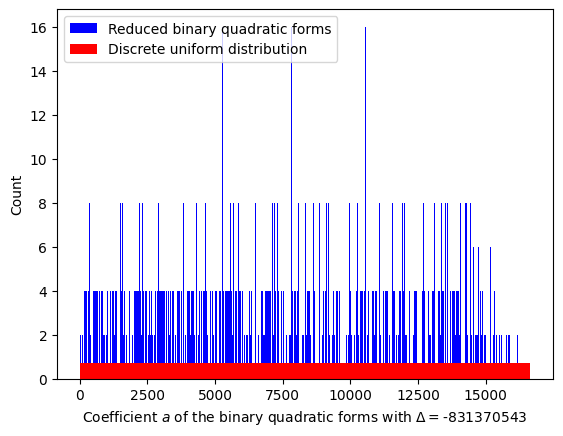

In [114]:
coefficientADensity = Counter(coefficientsA)
#print(coefficientADensity)
key = coefficientADensity.keys()
values = coefficientADensity.values()
print("Number of reduced forms:",sum(values))
print("Character:",(sum(values)*3.1415926)/math.sqrt(-discriminant))

## Distribution of the coefficient "A" in the studied class group of imaginary quadratic field
allCoefficientADensity = Counter(allCoefficientsA)
allKey = allCoefficientADensity.keys()
allValues = allCoefficientADensity.values()

#print(allCoefficientADensity)
## Uniform distribution 
uniformX = [i for i in range(rangeA)]
uniformY = [sum(values)/rangeA for i in range(rangeA)]

#plt.bar(allKey, allValues, width=4, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.bar(uniformX, uniformY, width=4, color='red', label='Discrete uniform distribution')
plt.xlabel('Coefficient $a$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
#plt.title("The distribution of coefficient $a$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientAdensity.pdf")
plt.show()

In [112]:
## Chi-squared test for the coefficient A
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
expectedInterval = [uniformY[0]*lenOfIntervals for i in range(numOfIntervals)]
observedInterval = [0]*numOfIntervals
print(lenOfIntervals)
for i in range(numOfIntervals):
    counter = 0
    for k in key:
        if i*lenOfIntervals<k and k<(i+1)*lenOfIntervals:
            counter+=coefficientADensity[k] 
    observedInterval[i] = counter
print("Expected discrete probability distribution for coefficient A", expectedInterval)
print("Observed discrete probability distribution for coefficient A", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

1665.0
Expected discrete probability distribution for coefficient A [1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9]
Observed discrete probability distribution for coefficient A [1345, 1350, 1288, 1330, 1274, 1372, 1324, 1322, 1174, 250]


Power_divergenceResult(statistic=861.7348906808545, pvalue=1.0832748286251192e-179)

KeyboardInterrupt: 

/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


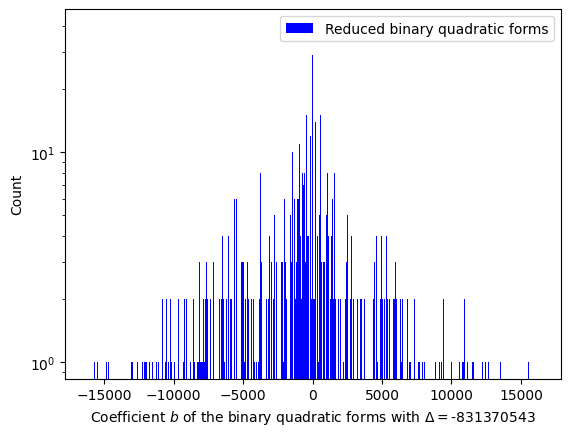

In [113]:
coefficientBDensity = Counter(coefficientsB)
key = coefficientBDensity.keys()
values = coefficientBDensity.values()

allCoefficientBDensity = Counter(allCoefficientsB)
allKey = allCoefficientBDensity.keys()
allValues = allCoefficientBDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $b$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
plt.yscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientBdensity.pdf")
plt.show()

In [109]:
## Chi-squared test for the coefficient B
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
observedInterval = [0]*numOfIntervals
for i in range(numOfIntervals):
    counter = 0
    print(i*lenOfIntervals)
    for k in key:
        if i*lenOfIntervals<=k and k<(i+1)*lenOfIntervals:
            counter+=coefficientBDensity[k] 
    observedInterval[i] = counter

expectedInterval = [sum(observedInterval)/numOfIntervals for i in range(numOfIntervals)]
print("Expected discrete probability distribution for coefficient B", expectedInterval)
print("Observed discrete probability distribution for coefficient B", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

0.0
1665.0
3330.0
4995.0
6660.0
8325.0
9990.0
11655.0
13320.0
14985.0
Expected discrete probability distribution for coefficient B [601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5]
Observed discrete probability distribution for coefficient B [2148, 1100, 816, 655, 452, 343, 252, 144, 72, 33]


Power_divergenceResult(statistic=6173.280964256027, pvalue=0.0)

In [ ]:
coefficientCDensity = Counter(coefficientsC)
key = coefficientCDensity.keys()
values = coefficientCDensity.values()


#allCoefficientCDensity = Counter(allCoefficientsC)
#allKey = allCoefficientCDensity.keys()
#allValues = allCoefficientCDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
#plt.hist(key)
plt.bar(key, values, width=2, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $c$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
plt.xscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientCdensity.pdf")
plt.show()

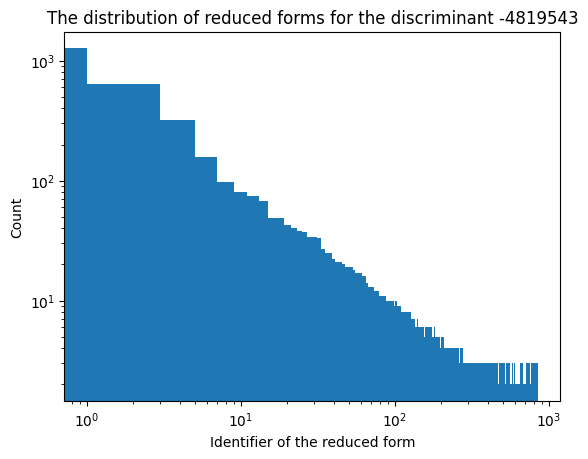

In [12]:
seenReducedFormDensity = Counter(seenReducedForms)
key = seenReducedFormDensity.keys()
values = seenReducedFormDensity.values()

plt.bar(key, values, width=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Identifier of the reduced form')
plt.ylabel("Count")
plt.title("The distribution of reduced forms for the discriminant "+str(discriminant))
plt.savefig("./Figures/reducedFormDist.pdf")
plt.show()

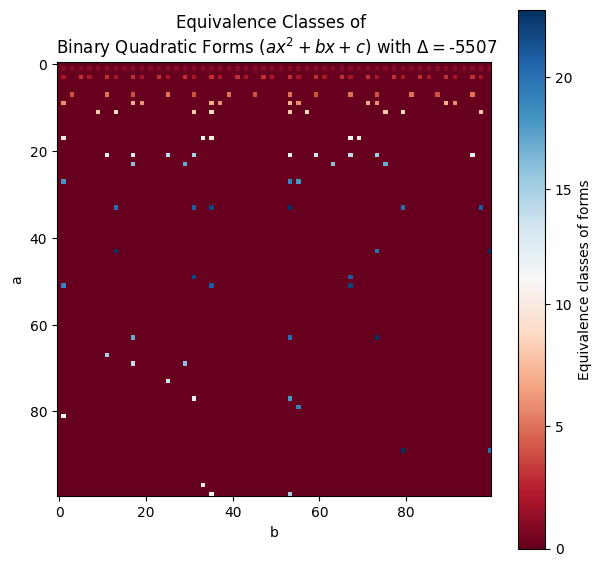

In [5]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.max()//2)
plt.imshow(classGroups,cmap=plt.cm.RdBu, norm=norm)
ax.set_aspect('equal')
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Equivalence classes of forms')
plt.savefig("./Figures/existingFormsWithDiscriminant.pdf")

[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800.]
[Text(-200.0, 0, '−200'), Text(0.0, 0, '0'), Text(200.0, 0, '200'), Text(400.0, 0, '400'), Text(600.0, 0, '600'), Text(800.0, 0, '800'), Text(1000.0, 0, '1000'), Text(1200.0, 0, '1200'), Text(1400.0, 0, '1400'), Text(1600.0, 0, '1600'), Text(1800.0, 0, '1800')]


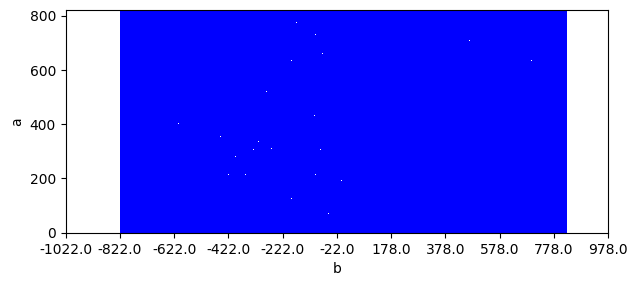

In [70]:
#classGroups = classGroups.transpose()
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
#ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
cmapmine = ListedColormap(['b', 'w'], N=2)
#norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.min())
plt.imshow(classGroups,cmap=cmapmine, vmin=0, vmax=1, interpolation='none')
#ax.set_aspect('equal')
plt.gca().invert_yaxis()
#cbar = plt.colorbar(orientation='vertical')
#cbar.set_label('Equivalence classes of forms')
# ytikcs
locs,labels = plt.xticks()
print(locs)
print(labels)
plt.xticks(locs, map(lambda x: x-classGroups.shape[0], locs))
plt.savefig("./Figures/coefficientAandBheatmap.pdf")

In [41]:
print(classGroups.shape[0])
print(classGroups.min(),classGroups.max())

20
0.0 1.0


In [263]:
## Orbit of a quadratic binary form by multiplying with a SL(Z,2) matrix

In [264]:
## Visualizing the class group operation via visualizing repeated squaring

In [128]:
## An implementation of Bach's algorithm
## Taken from here: https://codegolf.stackexchange.com/questions/265857/random-factorized-numbers
def gen_factor(N,disc):
    while True:
        j = random.randint(1, N.bit_length() - 1)
        q = (1 << j) + random.randrange(1 << j)
        if q > N:
            continue
        Nt = N // q
        if random.random() >= math.log(q, N) * (((Nt + 1) >> 1) << j) / N:
            continue
        p, a = sympy.perfect_power(q) or (q, 1)
        if random.random() >= 1 / a:
            continue
        ## Additional check: Legendre symbol disc mod p must be 1
        if sympy.isprime(p) and (p==2 or libnum.jacobi(disc,p)==1 ):
            return p, a, Nt

## Little modification: we should only care about prime factors that satisfy certain requirements
## For instance, Legendre symbol disc mod p must be 1
def bach(N, disc):
    if N <= 10**2:
        x = random.randint(N//2 + 1, N)
        return x, sympy.factorint(x)
    while True:
        p, a, Nt = gen_factor(N,disc)
        newx, factx = bach(Nt, disc)
        newx *= p ** a
        if random.random() < math.log(N / 2, newx):
            factx[p] = factx.get(p, 0) + a
            return newx, factx


def gen(n):
    return bach((1 << n) - 1)

In [129]:
print(bach(2**1000+5)[1])

TypeError: bach() missing 1 required positional argument: 'disc'

In [130]:
## This algorithm was suggested by Benjamin Wesolowski and implemented by Giacomo Pope
## Room for improvement: only generates class group elements of the form (p,b,c) for some prime
## Hence, not a surjective mapping to the class group. 
def random_ClassGroupElement(discriminant,a): #a should be a random prime
    D_mod_a = discriminant % a
    if libnum.jacobi(D_mod_a,a)==1:
        b = next(libnum.sqrtmod_prime_power(discriminant, a,1)) ## 1 is the power of the prime so mod a^1
    else:
        return (-1,0)
    #print("first",discriminant,a,b,(b*b-discriminant) / (4*a))
    if b == 0:
        return (-2,0)
    if b % 2 == 0:
        b = (a - b)
    ##if discriminant % 4 == 0:
    ##    b = crt([b, 2], [(a, 1), (2, 2)], 4*a)
    # c = int((b*b-discriminant) / (4*a))
    #print("second",discriminant,a,b,c)
    myForm = BQuadForm(a,b,disc=discriminant)
    if myForm.c == 0 or b*b-4*a*myForm.c!=discriminant: #((b*b-discriminant)%(4*a)) != 0 or
        return (-3,0)
    sign = randint(0,1)
    if sign:
        return  (a, b)
    return  (a, -b)

In [157]:
## This algorithm is a faster version of the previous algorithm using Bach's algorithm
def random_ClassGroupElementFaster(maxNum, discriminant): 
    a = bach(maxNum, discriminant)
    modSqrts = []
    #print(a[0], a[1])
    for k in a[1]: ##loop through the factors of a
        try:
            mySqrt = next(libnum.sqrtmod_prime_power(discriminant,k,a[1][k]))
            modSqrts.append(mySqrt)
        except ValueError as ve:
            return (0,0)
        
    primePowers = [k**a[1][k] for k in a[1]]
    b = libnum.solve_crt(modSqrts, primePowers)
    #myForm = BQuadForm(a[0],b,disc=discriminant)
    #return myForm
    return (a[0],b)
    
    if myForm.c == 0 or b*b-4*a*myForm.c!=discriminant: #((b*b-discriminant)%(4*a)) != 0 or
        return (-3,0)
    sign = randint(0,1)
    if sign:
        return  (a, b)
    return  (a, -b)

In [158]:
myDisc = -libnum.generate_prime(30,30)
print(myDisc)
random_ClassGroupElementFaster(2**14,myDisc)

-838966069


(0, 0)

In [174]:
## Benchmarking the faster version of the Wesolowski hash function using Bach's algorithm
howManyTimes = 100
bitLengths = [i for i in range(256,4097,256)]
outcnt = 0
measuredTimesWesolowskiFaster = []
measuredAttempts = []


for bitLength in bitLengths:   
    myDiscriminant = 0
    while -myDiscriminant%4 != 1: ## we can only use discriminants%4 = 1
        myDiscriminant = libnum.generate_prime(bitLength,30)
    #print(math.log(myDiscriminant,2),-myDiscriminant)
    
    # Start timer
    start_time = time.time()
    
    cnt = 0
    attempts = 0
    
    upperBound = 2**(bitLength//2-2)
    while cnt!=howManyTimes:
        (a,b) = random_ClassGroupElementFaster(upperBound,-myDiscriminant)
        if b!=0:
            cnt+=1
            #print(cnt)

    # End timer
    end_time = time.time()
    outcnt+=1
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    measuredTimesWesolowskiFaster.append(elapsed_time/howManyTimes)
    print("Sampling (Wesolowski Faster) 1 group element with a "+str(bitLength)+"-bit discriminant: ", elapsed_time/howManyTimes)

Sampling (Wesolowski Faster) 1 group element with a 256-bit discriminant:  0.021359102725982668
Sampling (Wesolowski Faster) 1 group element with a 512-bit discriminant:  0.04215928077697754
Sampling (Wesolowski Faster) 1 group element with a 768-bit discriminant:  0.08678751945495605
Sampling (Wesolowski Faster) 1 group element with a 1024-bit discriminant:  0.08848790168762206
Sampling (Wesolowski Faster) 1 group element with a 1280-bit discriminant:  0.15407362937927246


StopIteration: 

In [175]:
## Benchmarking the original version of the Wesolowski hash function
howManyTimes = 100
bitLengths = [i for i in range(256,4097,256)]
outcnt = 0
measuredTimes = []
measuredAttempts = []


for bitLength in bitLengths:   
    myDiscriminant = 0
    while -myDiscriminant%4 != 1: ## we can only use discriminants%4 = 1
        myDiscriminant = libnum.generate_prime(bitLength,30)
    #print(math.log(myDiscriminant,2),-myDiscriminant)
    
    # Start timer
    start_time = time.time()
    
    cnt = 0
    attempts = 0
    # The hashing algorithm by Benjamin&Giacomo
    while cnt!=howManyTimes:
        p = libnum.generate_prime(bitLength//2-2,30)
        if p==2:
            continue
        (a,b) = random_ClassGroupElement(-myDiscriminant,p)
        if p!=a:
            continue
        #print(attempts, -myDiscriminant,a,b)
        if b!=0:
            cnt+=1

    # End timer
    end_time = time.time()
    outcnt+=1
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    measuredTimes.append(elapsed_time/howManyTimes)
    measuredAttempts.append(attempts)
    print("Time for sampling (Wesolowski) 1 random group element with a "+str(bitLength)+"-bit discriminant: ", elapsed_time/howManyTimes)


Time for sampling (Wesolowski) 1 random group element with a 256-bit discriminant:  0.007155420780181884
Time for sampling (Wesolowski) 1 random group element with a 512-bit discriminant:  0.02372182846069336
Time for sampling (Wesolowski) 1 random group element with a 768-bit discriminant:  0.05468519926071167
Time for sampling (Wesolowski) 1 random group element with a 1024-bit discriminant:  0.12064820051193237
Time for sampling (Wesolowski) 1 random group element with a 1280-bit discriminant:  0.28374691009521485


KeyboardInterrupt: 

In [6]:
## This hashing algorithm is inspired by the CSIDH construction
## See the original CSIDH paper here (page 13): https://eprint.iacr.org/2018/383.pdf
def random_ClassGroupElementCSIDH(discriminant, primeIdeals, seed):
    ## In our applications, the discriminant will always be a large odd prime
    ## We initialize the random form to be the identity element in the class group
    randomForm = BQuadForm(1,1, disc=discriminant)
    for i in range(len(primeIdeals)):
        if seed & (1 << i) != 0:
            randomForm = randomForm.__mul__(primeIdeals[i])
    return randomForm

In [7]:
primes = []
with open('primes.json') as f:
   primes=json.load(f)

In [48]:
howManyTimes = 100
bitLengthsCSIDH = [i for i in range(16,129,1)]
outcnt = 0
measuredTimesCSIDH = []
measuredAttemptsCSIDH = []

for bitLength in bitLengthsCSIDH:
    ## Generate correct discriminant of size bitLength
    myDiscriminant = 0
    while -myDiscriminant%4 != 1: ## we can only use discriminants%4 = 1
        myDiscriminant = libnum.generate_prime(bitLength,30)
    myDiscriminant = -myDiscriminant
    ## Preprocessing
    primeIdeals = []
    cnt = 1 # we skip 2 from the list of primes
    while len(primeIdeals)!=bitLength:
        (a,b)=random_ClassGroupElement(myDiscriminant,primes[cnt])
        if b!=0:
            primeIdeals.append(BQuadForm(a,b, disc=myDiscriminant))     
        cnt+=1
        
    print(bitLength,cnt) 
    # Start timer
    start_time = time.time()
    
    for i in range(howManyTimes):
        s = random.randint(0, (2**bitLength) - 1)
        a=random_ClassGroupElementCSIDH(myDiscriminant,primeIdeals,s)

    # End timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    measuredTimesCSIDH.append(elapsed_time/howManyTimes)
    print("Time for sampling 1 random class group element with a "+str(math.ceil(math.log(-myDiscriminant,2)))+"-bit discriminant: ", elapsed_time/howManyTimes) 

16 86
Time for sampling 1 random class group element with a 16-bit discriminant:  0.00014307260513305665
17 166
Time for sampling 1 random class group element with a 17-bit discriminant:  0.00018491029739379884
18 33
Time for sampling 1 random class group element with a 18-bit discriminant:  0.00013467073440551758
19 45
Time for sampling 1 random class group element with a 19-bit discriminant:  0.00013749122619628905
20 59
Time for sampling 1 random class group element with a 20-bit discriminant:  0.00015294075012207032
21 43
Time for sampling 1 random class group element with a 21-bit discriminant:  0.0002094388008117676
22 40
Time for sampling 1 random class group element with a 22-bit discriminant:  0.00016685724258422852
23 56
Time for sampling 1 random class group element with a 23-bit discriminant:  0.00018467187881469728
24 42
Time for sampling 1 random class group element with a 24-bit discriminant:  0.00017014980316162109
25 50
Time for sampling 1 random class group element wi

96 174
Time for sampling 1 random class group element with a 96-bit discriminant:  0.00199310302734375
97 199
Time for sampling 1 random class group element with a 97-bit discriminant:  0.0020579409599304197
98 207
Time for sampling 1 random class group element with a 98-bit discriminant:  0.0020243144035339356
99 194
Time for sampling 1 random class group element with a 99-bit discriminant:  0.00210341215133667
100 175
Time for sampling 1 random class group element with a 100-bit discriminant:  0.002144792079925537
101 206
Time for sampling 1 random class group element with a 101-bit discriminant:  0.0022121596336364745
102 214
Time for sampling 1 random class group element with a 102-bit discriminant:  0.002185239791870117
103 211
Time for sampling 1 random class group element with a 103-bit discriminant:  0.002344231605529785
104 218
Time for sampling 1 random class group element with a 104-bit discriminant:  0.002340090274810791
105 233
Time for sampling 1 random class group elemen

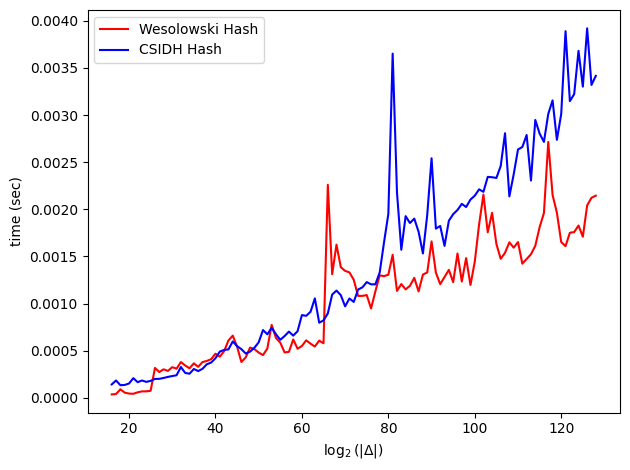

In [50]:
plt.plot(bitLengths,measuredTimes,color='red',label='Wesolowski Hash')
plt.plot(bitLengths,measuredTimesCSIDH,color='blue',label='CSIDH Hash')
plt.xlabel('$\log_2(|\Delta|)$')
plt.ylabel('time (sec)')
#plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("./Figures/hashFunctionRunningTimesSmallParams.pdf")
#plt.savefig("./Figures/hashFunctionRunningTimesCryptographicParams.pdf")
plt.show()

[ 16  24  32  40  48  56  64  72  80  88  96 104 112] 13


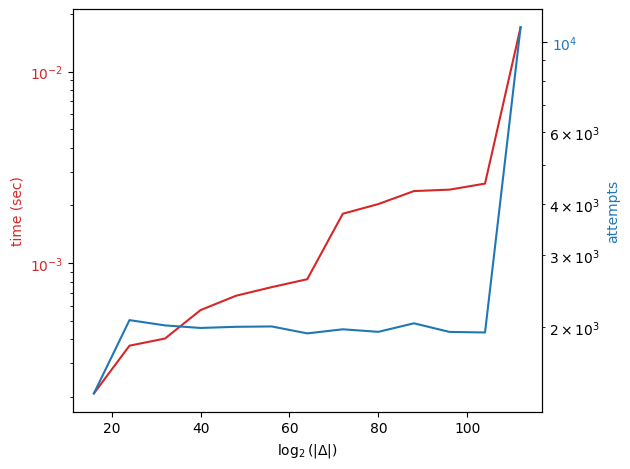

In [95]:
## Let us plot the number attempts on one of the y-axis, while on the other, we plot
## the number it took on average to hash using Wesolowski's hash to BQForm construction
# Create some mock data
t = np.array(bitLengths)
data1 = measuredTimes ##time to hash on average
data2 = measuredAttempts ##number of attempts
print(t,len(data1))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('$\log_2(|\Delta|)$')
ax1.set_ylabel('time (sec)', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('attempts', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./Figures/performanceWesolowskiTimevsAttempts.pdf")
plt.show()

In [20]:
print(len(primes))

0


coefficient of determination: 0.9180938774040386
intercept: -0.00024761233956385894
slope: [1.6918192e-05]
predicted response:
[[2.30787318e-05]
 [3.99969238e-05]
 [5.69151158e-05]
 [7.38333077e-05]
 [9.07514997e-05]
 [1.07669692e-04]
 [1.24587884e-04]
 [1.41506076e-04]
 [1.58424268e-04]
 [1.75342460e-04]
 [1.92260651e-04]
 [2.09178843e-04]
 [2.26097035e-04]
 [2.43015227e-04]
 [2.59933419e-04]
 [2.76851611e-04]
 [2.93769803e-04]
 [3.10687995e-04]
 [3.27606187e-04]
 [3.44524379e-04]
 [3.61442571e-04]
 [3.78360763e-04]
 [3.95278955e-04]
 [4.12197147e-04]
 [4.29115339e-04]
 [4.46033531e-04]
 [4.62951723e-04]
 [4.79869915e-04]
 [4.96788107e-04]
 [5.13706299e-04]
 [5.30624491e-04]
 [5.47542683e-04]
 [5.64460875e-04]
 [5.81379067e-04]
 [5.98297259e-04]
 [6.15215451e-04]
 [6.32133643e-04]
 [6.49051834e-04]
 [6.65970026e-04]
 [6.82888218e-04]
 [6.99806410e-04]
 [7.16724602e-04]
 [7.33642794e-04]
 [7.50560986e-04]
 [7.67479178e-04]
 [7.84397370e-04]
 [8.01315562e-04]
 [8.18233754e-04]
 [8.35151

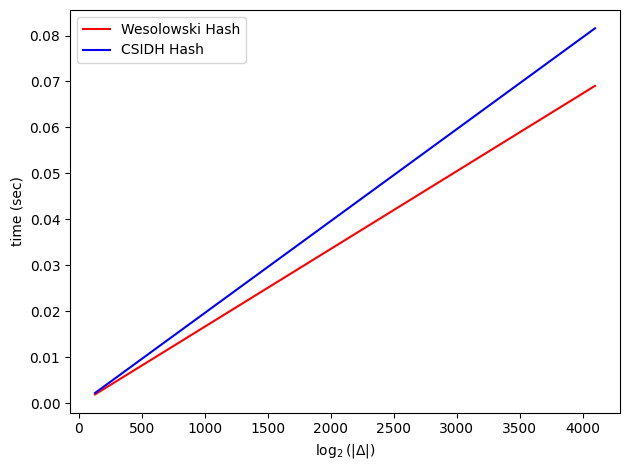

In [82]:
## Linear regression for the running time
## Useful link for Linear regression in Python
## Wesolowski linear regression
x = np.array(bitLengths).reshape((-1, 1))
y = np.array(measuredTimes)
model = LinearRegression()
model.fit(x, y)
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
y_pred = model.intercept_ + model.coef_ * x
print(f"predicted response:\n{y_pred}")

##CSIDHash linear regression
xCS = np.array(bitLengthsCSIDH).reshape((-1, 1))
yCS = np.array(measuredTimesCSIDH)
modelCS = LinearRegression()
modelCS.fit(xCS, yCS)
modelCS = LinearRegression().fit(xCS, yCS)
rCS_sq = modelCS.score(xCS, yCS)
print(f"coefficient of determination: {rCS_sq}")
print(f"intercept: {modelCS.intercept_}")
print(f"slope: {modelCS.coef_}")
yCS_pred = modelCS.intercept_ + modelCS.coef_ * xCS




xNew = np.array([i for i in range(128,4097,128)]).reshape((-1, 1))
y_pred = model.intercept_ + model.coef_ * xNew
xNewCS = np.array([i for i in range(128,4097,128)]).reshape((-1, 1))
yCS_pred = modelCS.intercept_ + modelCS.coef_ * xNew

plt.plot(xNew,y_pred,color='red', label='Wesolowski Hash')
plt.plot(xNew,yCS_pred,color='blue',label='CSIDH Hash')
plt.legend()
plt.xlabel('$\log_2(|\Delta|)$')
plt.ylabel('time (sec)')
plt.tight_layout()
plt.savefig("./Figures/hashFunctionRunningTimes.pdf")
plt.show()

In [278]:
len(primes)

1000026

In [117]:
print(xNew[1])

[256]


In [64]:
## How much time it takes to uniformly random generate a j-bit random prime?
## Likely this operation is our biggest bottleneck in our proposed hash functions
howManyTimes = 10
bitLengths = [256*i for i in range(1,10)]
measuredPrimeGensTimes = np.zeros((len(bitLengths),howManyTimes))
cnt = 0
for j in bitLengths: 
    for i in tqdm(range(howManyTimes)):
        start_time = time.time()
        libnum.generate_prime(j,30)
        end_time = time.time()
        measuredPrimeGensTimes[cnt][i]=end_time-start_time
    cnt+=1
    print(j,"-bit random prime generation time on average:",(end_time-start_time)/howManyTimes, "seconds")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 83.41it/s]


256 -bit random prime generation time on average: 0.0007810831069946289 seconds


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.86it/s]


512 -bit random prime generation time on average: 0.0049923181533813475 seconds


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.05it/s]


768 -bit random prime generation time on average: 0.008315420150756836 seconds


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


1024 -bit random prime generation time on average: 0.03401541709899902 seconds


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


1280 -bit random prime generation time on average: 0.05448217391967773 seconds


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


1536 -bit random prime generation time on average: 0.05331580638885498 seconds


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.17s/it]


1792 -bit random prime generation time on average: 0.08035650253295898 seconds


100%|███████████████████████████████████████████| 10/10 [00:36<00:00,  3.68s/it]


2048 -bit random prime generation time on average: 0.25159850120544436 seconds


100%|███████████████████████████████████████████| 10/10 [01:44<00:00, 10.40s/it]

2304 -bit random prime generation time on average: 1.3256738901138305 seconds


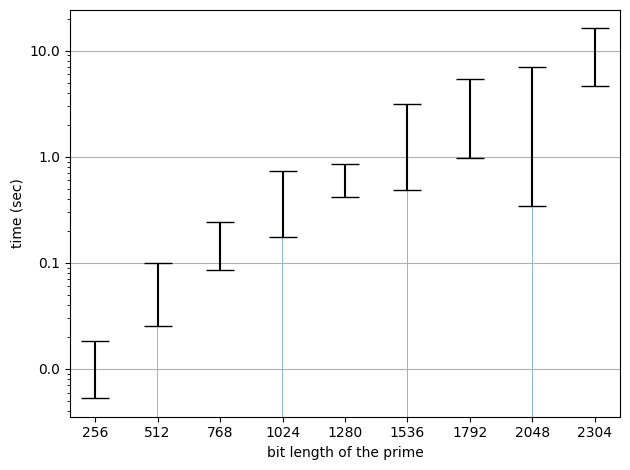

In [65]:
means = [np.mean(measuredPrimeGensTimes[i]) for i in range(len(bitLengths))]
stds = [np.std(measuredPrimeGensTimes[i]) for i in range(len(bitLengths))]
#writtenBitLengths = ["128","256","512","1024"]

fig, ax = plt.subplots()
ax.bar(bitLengths, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('time (sec)')
ax.set_xlabel('bit length of the prime')
ax.set_xticks(bitLengths)
#ax.set_xticklabels(writtenBitLengths)
ax.yaxis.grid(True)
ax.set_yscale('log')
#ax.set_xscale('log')

from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

# Save the figure and show
plt.tight_layout()
plt.savefig('./Figures/primeGenTimes.pdf')
plt.show()

In [75]:
## How much time it takes to compute the class group operation?
howManyTimes = 100
bitLengths = [256*i for i in range(1,10)]
measuredPrimeGensTimes = np.zeros((len(bitLengths),howManyTimes))
cnt = 0
for j in bitLengths:
    discriminant =0
    while discriminant%4!=3:
        discriminant = libnum.generate_prime(j,30)
    identityForm = BQuadForm(1,1, disc=-discriminant)
    random1Form = identityForm.__mul__(identityForm)
    random2Form = random1Form.__mul__(random1Form)
    for i in tqdm(range(howManyTimes)):
        start_time = time.time()
        random1Form = random1Form.__mul__(random2Form)
        end_time = time.time()
        measuredPrimeGensTimes[cnt][i]=end_time-start_time
    cnt+=1
    print(j,"-bit class group opeartion time on average:",(end_time-start_time)/howManyTimes, "seconds")

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 27546.99it/s]


256 -bit class group opeartion time on average: 2.5033950805664064e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 29808.14it/s]


512 -bit class group opeartion time on average: 3.1948089599609377e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 39416.45it/s]


768 -bit class group opeartion time on average: 2.09808349609375e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 32658.29it/s]


1024 -bit class group opeartion time on average: 2.6226043701171877e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 27360.10it/s]


1280 -bit class group opeartion time on average: 3.3140182495117185e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 22686.63it/s]


1536 -bit class group opeartion time on average: 3.8862228393554685e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 20010.99it/s]


1792 -bit class group opeartion time on average: 4.6253204345703124e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 16308.19it/s]


2048 -bit class group opeartion time on average: 5.507469177246094e-07 seconds


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 13896.25it/s]

2304 -bit class group opeartion time on average: 6.604194641113281e-07 seconds


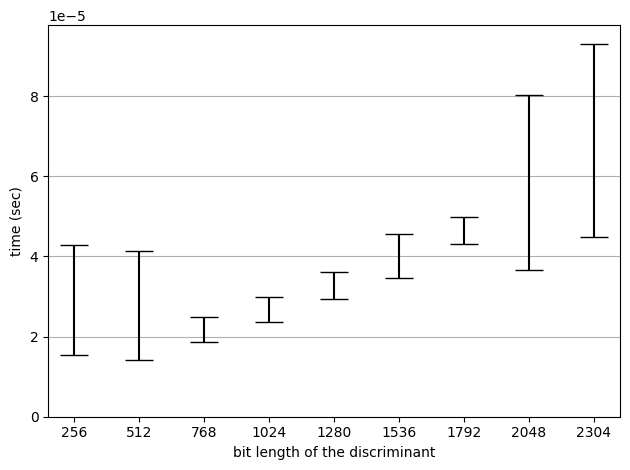

In [76]:
means = [np.mean(measuredPrimeGensTimes[i]) for i in range(len(bitLengths))]
stds = [np.std(measuredPrimeGensTimes[i]) for i in range(len(bitLengths))]
#writtenBitLengths = ["128","256","512","1024"]

fig, ax = plt.subplots()
ax.bar(bitLengths, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('time (sec)')
ax.set_xlabel('bit length of the discriminant')
ax.set_xticks(bitLengths)
#ax.set_xticklabels(writtenBitLengths)
ax.yaxis.grid(True)
#ax.set_yscale('log')
#ax.set_xscale('log')

from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

# Save the figure and show
plt.tight_layout()
plt.savefig('./Figures/classGroupGenTimes.pdf')
plt.show()